In [1]:
import numpy as np
import glob
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.filters import sobel
from sklearn.model_selection import train_test_split

SIZE = 128

In [2]:
data_img = []
data_label = [] 
for dir_path in glob.glob("Dataset/*"):
    label = dir_path.split("/")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(dir_path, "*.jpg")):
#         print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (SIZE, SIZE))
        data_img.append(img)
        data_label.append(label)
        
data_img = np.array(data_img)
data_label = np.array(data_label)

normal
potholes


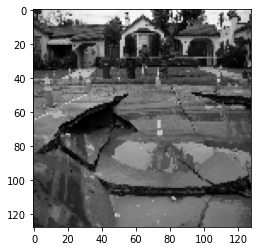

In [3]:
plt.imshow(data_img[355], cmap='gray')

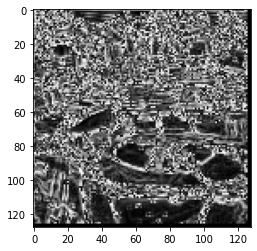

In [4]:
def convolve2D(image, kernel, padding=0, strides=1):
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
#         print(imagePadded)
    else:
        imagePadded = image

    # Iterate through image
    for y in range(image.shape[1]):
        # Exit Convolution
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break

    return output

def sobel_detection(img):
    g_x = [[1, 0, -1]
          ,[2, 0, -2]
          ,[3, 0, -3]]
    
    g_y = [[1, 2, 3]
         ,[0, 0, 0]
         ,[-1, -2, -3]]
    
    h_x = convolve2D(img, g_x, padding=1)
    h_y = convolve2D(img, g_y, padding=1)
    
    sobel = ((h_x**2 + h_y**2)**0.5) % 256
    
    return sobel

sobel_img = sobel_detection(data_img[355])
plt.imshow(sobel_img, cmap='gray')

In [5]:
def image_preprocessing(dataset):
    new_dataset = []
    for image in dataset:
        sobel_img = sobel_detection(image)
        new_dataset.append(sobel_img)
    return np.array(new_dataset)

def feature_extractor(dataset):
    new_dataset = []
    for image in dataset:
        image_flatten = image.flatten()
        new_dataset.append(image_flatten)
    new_dataset = np.array(new_dataset)
    # normalisasi
    new_dataset = new_dataset / 255.0
    return new_dataset

In [6]:
preprocess_img = image_preprocessing(data_img)
feature_img = feature_extractor(preprocess_img)

In [7]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(data_label)
data_encoded = le.transform(data_label)

x_train, x_test, y_train, y_test = train_test_split(feature_img, data_encoded, test_size=0.2)

In [8]:
from sklearn import svm
SVM_model = svm.SVC(decision_function_shape='ovo')
SVM_model.fit(x_train, y_train)

SVC(decision_function_shape='ovo')

In [9]:
test_prediction = SVM_model.predict(x_test)

In [10]:
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, test_prediction))

Accuracy =  0.8125


<AxesSubplot:>

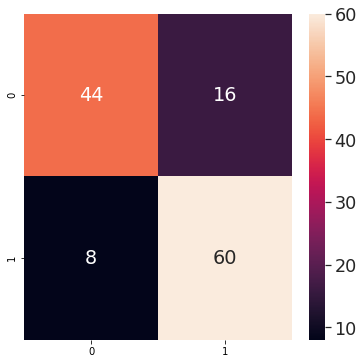

In [11]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, test_prediction)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, ax=ax)
